In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import string
import re
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv('input/Transaction_Naration_Data_Set.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['AC_ID'] = pd.Categorical(df['AC_ID'])

In [3]:
df.head()

,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR
0,3644877,342800.00,01-NOV-22,Cash Withdraw,Debit
1,1175256,342800.00,01-NOV-22,Cash Withdrawal From A/C No.:,Credit
2,2298226,1500.00,01-NOV-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit
3,4066427,1500.00,01-NOV-22,Credit Against Merchant Cash Withdraw Service ...,Credit
4,1978564,2550.00,01-NOV-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from autocorrect import Speller
spell = Speller(lang='en')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from nltk.metrics.distance import jaro_winkler_similarity
import re
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()
import spacy
spl = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# spacy lemmatization demo
sentence = "The striped bats are banking bank on their feet for best a b c au pu da f ac bd"

# Parse the sentence using the loaded 'en' model object `nlp`
doc = spl(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])
#> 'the strip bat be hang on -PRON- foot for good'

'the stripe bat be bank bank on their foot for good a b c au pu da f ac bd'

In [6]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)



True

In [7]:
stops = ['ac', 'ae', 'md', 'akter', 'hossain', 'rahman', 'ltd', 'bazar', 'unnayan', 'dol', 'mohila', 'ad', 'mia', 'ali', 'uddin',
         'begum', 'tk', 'islam', 'amt', 'abdul', 'hasan', 'sonali', 'alam', 'miah', 'bangladesh', 'per', 'taka',
         'da', 'vai', 'ahmed', 'hossen', 'khan', 'abu', 'al', 'unnayon', 'b', 'amin', 'mamun', 'khatun', 'unnoyon',  'nur', 'haque']
notSure = ['mo', 'cap', 'br', 'id', 'dal', 'self', 'abdullah', 'abdulla', 'pls', 'mullapara', 'joitapur', 'joytapur',
           'purush', 'purpose', 'title', 'para']
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october',
          'november', 'december', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
keep_words = ['eftn', 'ft', 'bkash', 'nogod', 'nagad', 'rtgs', 'pos', 'polli', 'biddut', 'palli', 'chalan', 'bidyut',
              'cib', 'paywell', 'challan', 'npsb', 'dps', 'atm', 'trf', 'sonod', 'bill', 'wrongly', 'vgd']
zillas = []
with open('file.txt', 'r') as f:
    for line in f:
        zillas.append(line.strip().lower())
print(zillas)
stop_words = stop_words + stops + notSure + months


['cumilla', 'debidwar', 'barura', 'brahmanpara', 'chandina', 'chauddagram', 'daudkandi', 'homna', 'laksam', 'muradnagar', 'nangalkot', 'cumillasadar', 'meghna', 'monohargonj', 'sadarsouth', 'titas', 'burichang', 'lalmai', 'feni', 'chhagalnaiya', 'sadar', 'sonagazi', 'fulgazi', 'parshuram', 'daganbhuiyan', 'brahmanbaria', 'sadar', 'kasba', 'nasirnagar', 'sarail', 'ashuganj', 'akhaura', 'nabinagar', 'bancharampur', 'bijoynagar', 'rangamati', 'sadar', 'kaptai', 'kawkhali', 'baghaichari', 'barkal', 'langadu', 'rajasthali', 'belaichari', 'juraichari', 'naniarchar', 'noakhali', 'sadar', 'companiganj', 'begumganj', 'hatia', 'subarnachar', 'kabirhat', 'senbug', 'chatkhil', 'sonaimuri', 'chandpur', 'haimchar', 'kachua', 'shahrasti', 'sadar', 'matlabsouth', 'hajiganj', 'matlabnorth', 'faridgonj', 'lakshmipur', 'sadar', 'kamalnagar', 'raipur', 'ramgati', 'ramganj', 'chattogram', 'rangunia', 'sitakunda', 'mirsharai', 'patiya', 'sandwip', 'banshkhali', 'boalkhali', 'anwara', 'chandanaish', 'satkani

In [8]:
zillas = set(zillas)
stop_words = set(stop_words).union(zillas)
def clean_narration(x):
    x = str(x).lower().strip()
    x = re.sub('[^a-zA-Z ]', ' ', x)
    x = " ".join(x.split())
    words = word_tokenize(x)
    # remove words which are in zillas and jaro_winkler_similarity > 0.85
    words = [w for w in words if w not in stop_words or w in keep_words]
    # words = [wnl.lemmatize(w) for w in words]
    sentence = " ".join(words)
    lemmatized = spl(sentence)
    words = [tok.lemma_ for tok in lemmatized]
    # remove 1 character words
    words = [w for w in words if len(w) > 1]
    return " ".join(words)
# clean_narration('Cash withdraw from Micro Merchant point, MM A/C')

In [9]:
unique_narration = df['NARATION'].drop_duplicates()
print(len(unique_narration))
# unique_narration.to_csv('input/narration.csv', index=False)

128604


In [10]:
unique_narration = unique_narration.apply(lambda x: clean_narration(x))
unique_narration = unique_narration[unique_narration != ""]
unique_narration = unique_narration.drop_duplicates()

In [11]:
# tokenize the whole unique_narration
tokenized_narration = unique_narration.apply(lambda x: word_tokenize(x))

In [12]:
narration_word_list = []
for i in tokenized_narration:
    narration_word_list += i

In [13]:
narration_word_set = set(narration_word_list)
print(len(narration_word_set))

29895


In [14]:
non_english = narration_word_set - set(nltk.corpus.words.words())
print(len(non_english))

26621


In [15]:
def fix_spelling(word):
    suggestions = sym_spell.lookup(
        word, Verbosity.TOP , max_edit_distance=2, include_unknown=True
    )
    return suggestions[0]
corrected=[]
for word in non_english:
    cw = fix_spelling(str(word))
    if cw.term == word:
        continue
    corrected.append(cw.term)
    
non_english = non_english - set(corrected)

In [16]:
print('selim' in corrected)

True


In [17]:
ignore = ['ripon', 'amir', 'jamal', 'nazim', 'babu', 'rana', 'kazi', 'rubel', 'jewel', 'heron',
          'hakim', 'boro', 'sharif', 'jowel', 'ismail', 'anam', 'sir', 'sarkar', 'babul',
          'ratan', 'joy', 'mehari', 'dey', 'sha', 'jihad', 'chan', 'saddam',
          'shahin', 'din', 'happy', 'osman', 'dash', 'ashraf', 'arafat', 'hanif', 'ala',
          'er', 'omar', 'rabbi', 'tania', 'selim', 'faisal', 'hafiz', 'mubarak']
non_english = non_english.union(set(ignore))


def prune_non_english(x):
    words = word_tokenize(x)
    words = [w for w in words if w not in non_english or w in keep_words]
    return " ".join(words)


unique_narration = unique_narration.apply(lambda x: prune_non_english(x))
unique_narration = unique_narration[unique_narration != ""]
unique_narration = unique_narration.drop_duplicates()
print(len(unique_narration))


19844


In [18]:
# word_dict = set()
# with open('words.txt', 'r') as f:
#     for line in f:
#         word_dict.add(line.strip().lower())
# print(len(word_dict))

In [19]:
unique_narration.to_csv('input/narration_cleaned_5.csv', index=False)

<Axes: >

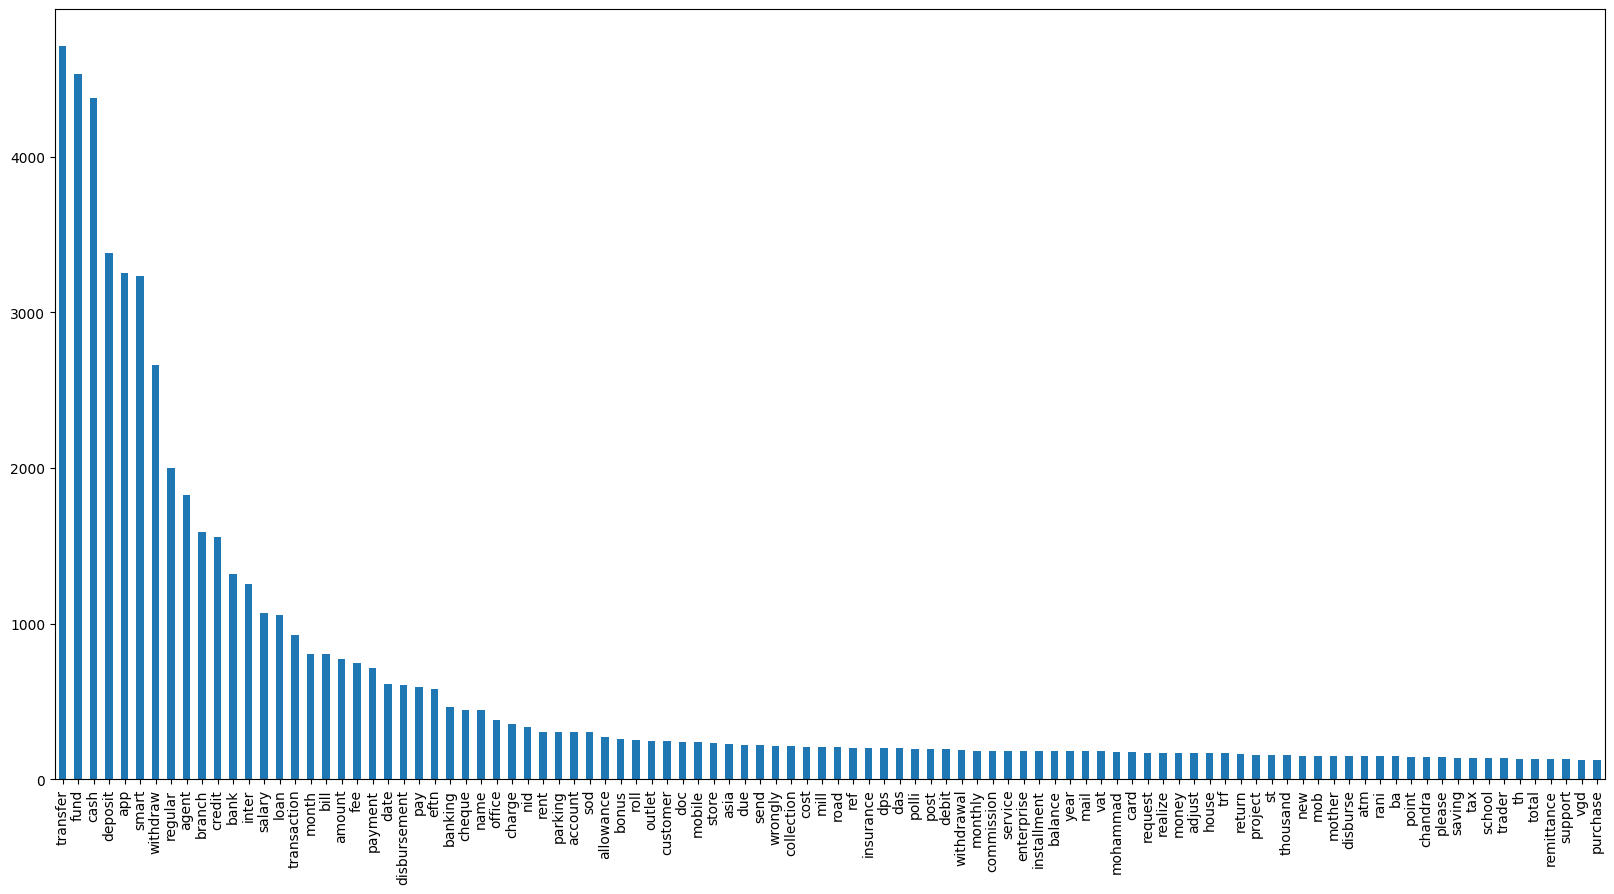

In [20]:
pd.set_option('display.max_rows', None)
pd.Series(' '.join(unique_narration).split()).value_counts()[:100].plot(kind='bar', figsize=(20, 10))

In [21]:
from gensim.models import Word2Vec
tokenized_narration = unique_narration.apply(lambda x: word_tokenize(x))
model = Word2Vec(tokenized_narration, min_count=3, vector_size=100, window=5, sg=1, workers=4, seed=1805010)

In [22]:
print(model.wv.most_similar('agent'))
print(model.wv.most_similar('withdraw'))
print(model.wv.most_similar('cash'))
print(model.wv.most_similar('deposit'))

[('branch', 0.7563861012458801), ('main', 0.7546976208686829), ('vgd', 0.754075825214386), ('outlet', 0.7486107349395752), ('sultan', 0.742844820022583), ('support', 0.7358542680740356), ('dev', 0.7303445339202881), ('alif', 0.7290746569633484), ('pal', 0.725290060043335), ('sub', 0.724833607673645)]
[('mob', 0.9138051867485046), ('phone', 0.9126722812652588), ('nid', 0.9113001227378845), ('deposit', 0.9083864688873291), ('say', 0.9044966101646423), ('depositor', 0.9023063778877258), ('bearer', 0.8955357670783997), ('pharmacy', 0.8883486390113831), ('ray', 0.8874204158782959), ('muhammad', 0.8869308233261108)]
[('say', 0.8215010762214661), ('pu', 0.8168129920959473), ('business', 0.7915648818016052), ('reno', 0.7817728519439697), ('center', 0.7787232995033264), ('inter', 0.7782438397407532), ('sultan', 0.778008759021759), ('pal', 0.7731615304946899), ('main', 0.7688819766044617), ('depositor', 0.768706738948822)]
[('withdraw', 0.9083865284919739), ('vgd', 0.8306649327278137), ('pu', 0.

In [23]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

tokenized_narration = unique_narration.apply(lambda x: word_tokenize(x))
X = vectorize(tokenized_narration, model=model)

In [24]:
print(len(X))
print(len(unique_narration))

19844
19844


In [25]:
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import scale

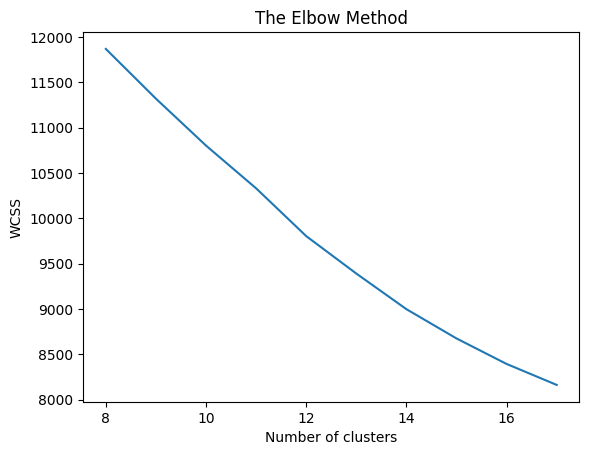

In [26]:
wcss = []

for i in range(8,18):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(8,18),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
num_clusters = 13
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10, verbose=True, random_state=1805010)
km.fit(X)

Initialization complete
Iteration 0, inertia 14081.794695011067.
Iteration 1, inertia 10617.858694324841.
Iteration 2, inertia 10199.578460909925.
Iteration 3, inertia 10030.485947080248.
Iteration 4, inertia 9932.435907747267.
Iteration 5, inertia 9846.993259928298.
Iteration 6, inertia 9775.466134865848.
Iteration 7, inertia 9750.847110594.
Iteration 8, inertia 9715.182121435664.
Iteration 9, inertia 9678.380293136364.
Iteration 10, inertia 9651.262786299445.
Iteration 11, inertia 9623.244160925022.
Iteration 12, inertia 9596.401930295151.
Iteration 13, inertia 9567.126131259685.
Iteration 14, inertia 9545.110670198854.
Iteration 15, inertia 9531.768659847674.
Iteration 16, inertia 9523.18863236931.
Iteration 17, inertia 9516.535266455281.
Iteration 18, inertia 9511.452382882784.
Iteration 19, inertia 9508.047386353179.
Iteration 20, inertia 9506.743020450682.
Iteration 21, inertia 9506.09007067612.
Iteration 22, inertia 9505.294070555447.
Iteration 23, inertia 9504.416409547317.
Ite

KMeans(max_iter=100, n_clusters=13, n_init=10, random_state=1805010,
       verbose=True)

In [28]:
df_clusters_KMeans = pd.DataFrame({
    "narrations": unique_narration,
    "tokens": tokenized_narration,
    "kmeans_cluster": km.labels_
})

df_clusters_KMeans.head()

,narrations,tokens,kmeans_cluster
0,cash withdraw,"[cash, withdraw]",3
1,cash withdrawal,"[cash, withdrawal]",3
2,cash withdraw micro merchant point,"[cash, withdraw, micro, merchant, point]",3
3,credit merchant cash withdraw service,"[credit, merchant, cash, withdraw, service]",3
6,cash deposit,"[cash, deposit]",3


8294 ['bill', 'office', 'cash'] []
2182 ['roll'] [244]
6839 ['withdraw'] [831]
17492 ['cash', 'deposit'] [3566, 2689]
8265 ['date', 'amount', 'agent'] []
1251 ['polly', 'polli', 'real'] []
3299 ['bank', 'transaction', 'eftn'] [650, 581, 572]
4993 ['salary'] [622]
2300 ['withdraw', 'nid'] [356, 298]
5559 ['credit'] [1042]
4802 ['loan'] [616]
24577 ['transfer', 'fund', 'app', 'smart'] [4120, 4016, 3215, 3210]
767 ['thousand'] [130]


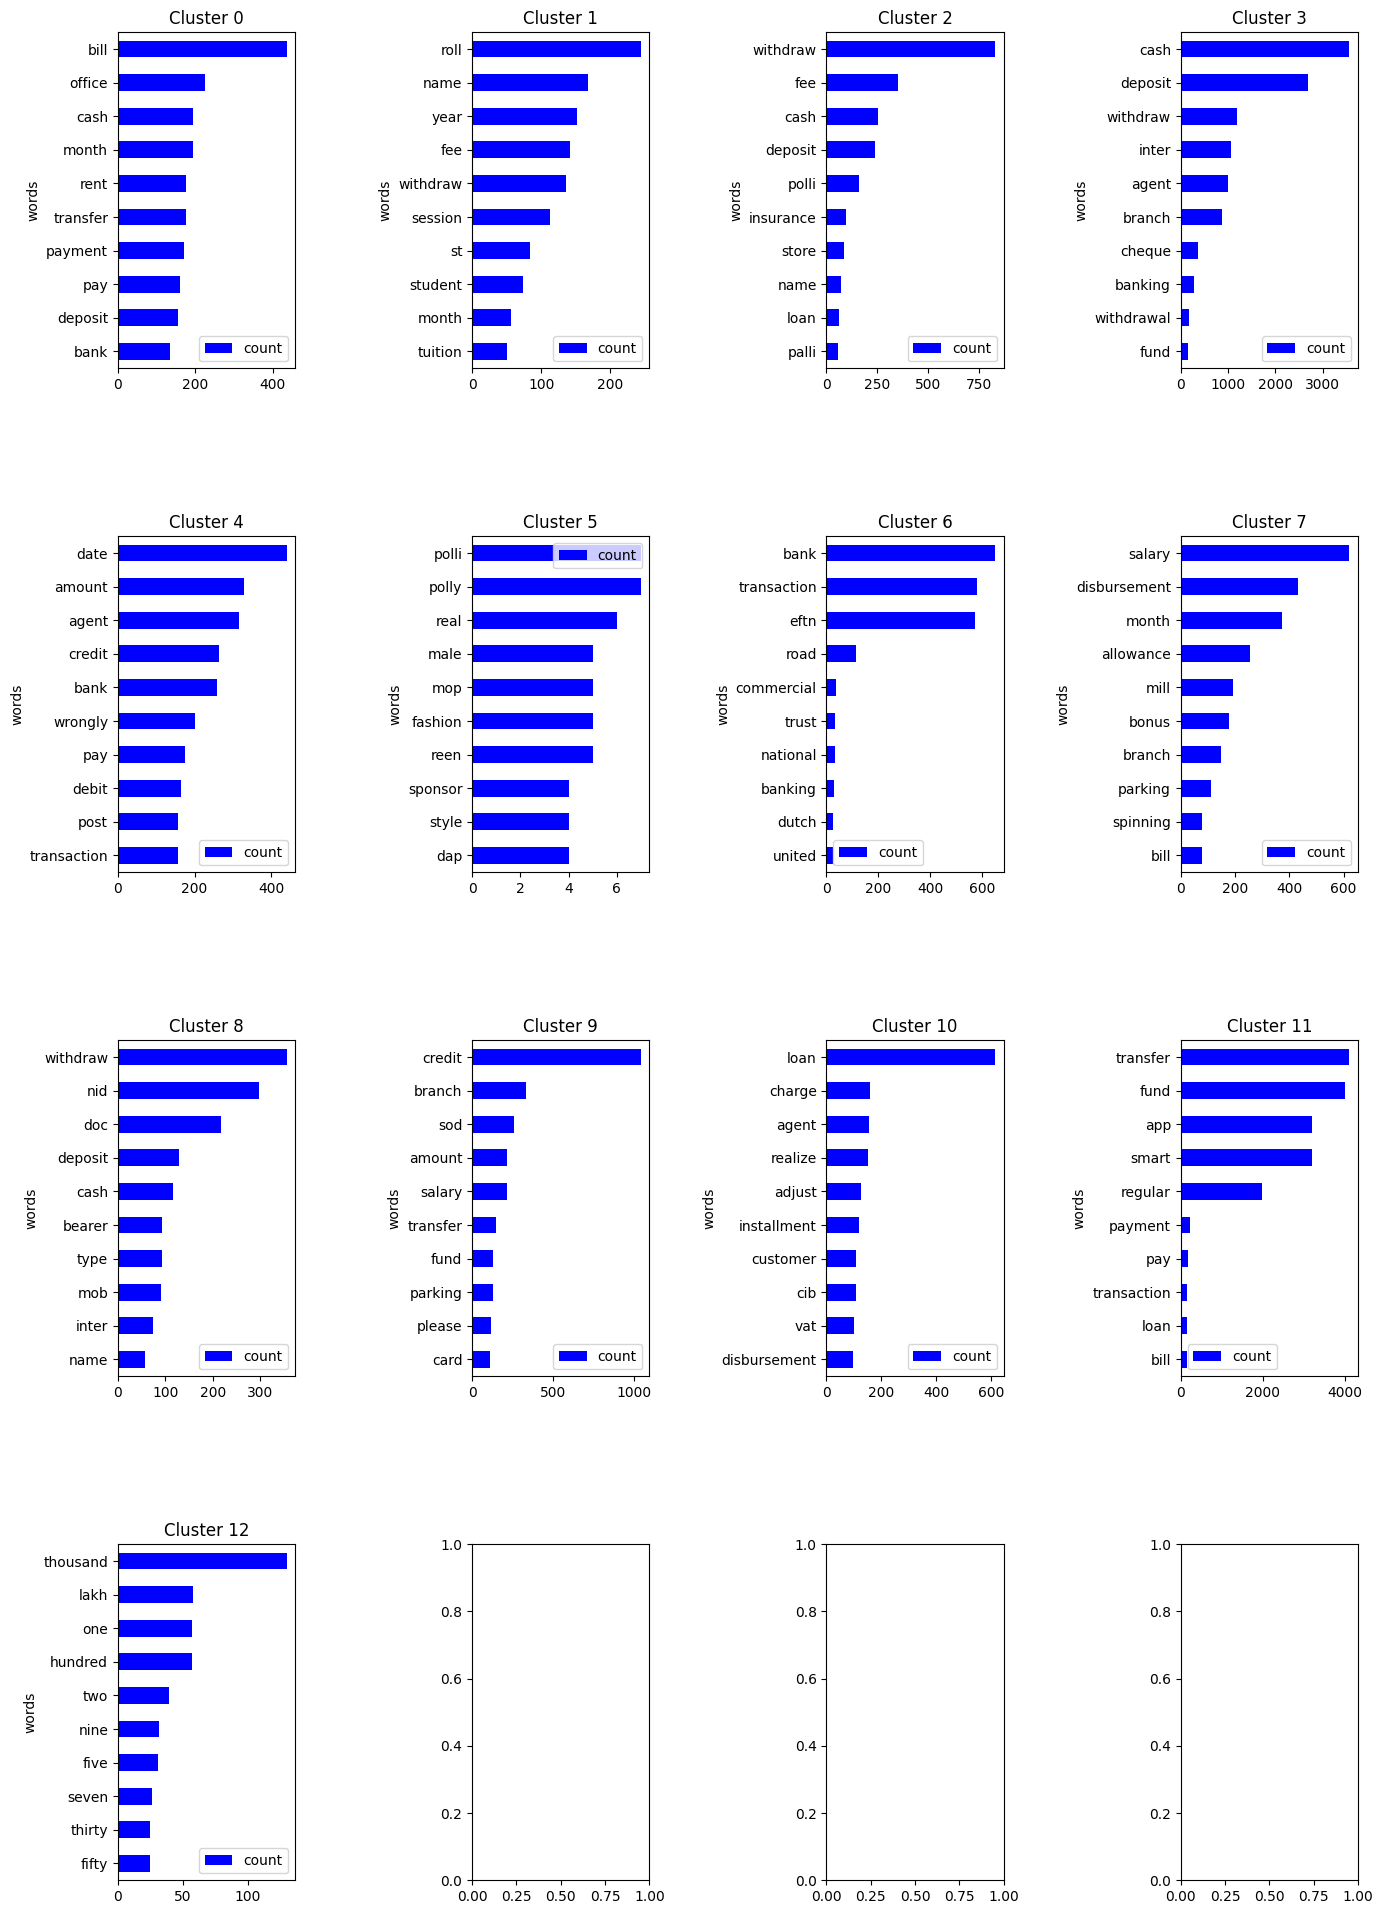

In [29]:
import itertools
import collections
import matplotlib.pyplot as plt

most_freq_words_kmeans = [[] for _ in range(num_clusters)]

def perClusterPlot(arr,ax,title,clusterNo):
  lemmatized_tokens = list(arr['tokens'])
  token_list = list(itertools.chain(*lemmatized_tokens))
  counts_no = collections.Counter(token_list)
  clean_tweets = pd.DataFrame(counts_no.most_common (10), columns=['words', 'count'])
  clean_tweets.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='blue', title=title)
  s = sum(counts_no.values())
  vals = [x[1] for x in counts_no.most_common (10) if (x[1] / s * 100.0) > 10.0]
  if len(vals) == 0:
    keys = [x[0] for x in counts_no.most_common (3)]
  elif len(vals) > 4:
    keys = [x[0] for x in counts_no.most_common (4)]
  else:
    keys = [x[0] for x in counts_no.most_common (len(vals))]
  print(s, keys, vals)
  most_freq_words_kmeans[clusterNo].append(keys)


fig, ax = plt.subplots(nrows=int(num_clusters / 4 + 1), ncols=4, figsize=(16, 24))
plt.subplots_adjust(wspace=1, hspace=0.5)
axe = ax.ravel()
for i in range(num_clusters):
   perClusterPlot(df_clusters_KMeans[df_clusters_KMeans["kmeans_cluster"] == i], axe[i], "Cluster " + str(i), i)


In [30]:
def preprocessing_pipeline(x):
    x = clean_narration(x)
    x = prune_non_english(x)
    return word_tokenize(x)

In [51]:
df = pd.read_csv('output/Test.csv')
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6
0,1,1175256,342800.00,01-Nov-22,Cash Withdrawal From A/C No.:,Credit,1
1,2,2298226,1500.00,01-Nov-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit,9
2,3,4066427,1500.00,01-Nov-22,Credit Against Merchant Cash Withdraw Service ...,Credit,9
3,4,1978564,2550.00,01-Nov-22,"Cash withdraw from Micro Merchant point, MM A/C",Debit,9
4,5,4890311,2550.00,01-Nov-22,Credit Against Merchant Cash Withdraw Service ...,Credit,9


In [52]:
pred_X = df['0.4']
pred_X.head()

0                       Cash Withdrawal From A/C No.: 
1     Cash withdraw from Micro Merchant point, MM A/C 
2    Credit Against Merchant Cash Withdraw Service ...
3     Cash withdraw from Micro Merchant point, MM A/C 
4    Credit Against Merchant Cash Withdraw Service ...
Name: 0.4, dtype: object

In [53]:
tok_X = pred_X.apply(lambda x: preprocessing_pipeline(x))
vect_X = vectorize(tok_X, model=model)

In [54]:
pred_Y = km.predict(vect_X)

In [55]:
pred_df = pd.DataFrame({
    "narrations": pred_X,
    "tokens": tok_X,
    "kmeans_cluster": pred_Y,
    "ground_truth": df['0.6'].dropna().apply(lambda x: int(x))
})

,narrations,tokens,kmeans_cluster,ground_truth
0,Cash Withdrawal From A/C No.:,"[cash, withdrawal]",3,1
1,"Cash withdraw from Micro Merchant point, MM A/C","[cash, withdraw, micro, merchant, point]",3,9
2,Credit Against Merchant Cash Withdraw Service ...,"[credit, merchant, cash, withdraw, service]",3,9
3,"Cash withdraw from Micro Merchant point, MM A/C","[cash, withdraw, micro, merchant, point]",3,9
4,Credit Against Merchant Cash Withdraw Service ...,"[credit, merchant, cash, withdraw, service]",3,9
5,Cash Deposit to A/C No.:,"[cash, deposit]",3,2
6,Cash Deposit,"[cash, deposit]",3,2
7,Cash Deposit to A/C No.:,"[cash, deposit]",3,2
8,Credit Against Merchant Purchase Payment Servi...,"[credit, merchant, purchase, payment, service]",0,10
9,"Cash withdraw from Micro Merchant point, MM A/C","[cash, withdraw, micro, merchant, point]",3,9
